In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [2]:
def convert_to_float(x):

    try:
        return float(x)
    except:
        return np.nan
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
df['z-axis'] = df['z-axis'].apply(convert_to_float)

df = df.dropna()

In [3]:
df.head(10)

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [7]:
df.info

<bound method DataFrame.info of          user activity        timestamp    x-axis     y-axis    z-axis
0          33  Jogging   49105962326000 -0.694638  12.680544  0.503953
1          33  Jogging   49106062271000  5.012288  11.264028  0.953424
2          33  Jogging   49106112167000  4.903325  10.882658 -0.081722
3          33  Jogging   49106222305000 -0.612916  18.496431  3.023717
4          33  Jogging   49106332290000 -1.184970  12.108489  7.205164
...       ...      ...              ...       ...        ...       ...
1098199    19  Sitting  131623331483000  9.000000  -1.570000  1.690000
1098200    19  Sitting  131623371431000  9.040000  -1.460000  1.730000
1098201    19  Sitting  131623411592000  9.080000  -1.380000  1.690000
1098202    19  Sitting  131623491487000  9.000000  -1.460000  1.730000
1098203    19  Sitting  131623531465000  8.880000  -1.330000  1.610000

[1098203 rows x 6 columns]>

In [15]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [21]:
np.array(segments).shape

#segments[0]
np.array(labels).shape

(54901,)

In [10]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
#np.array(labels).shape
#labels[3]

In [13]:
reshaped_segments.shape

#labels[0]

(54901, 200, 3)

In [11]:
labels.shape

(54901, 6)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [11]:
len(X_train)

43920

In [12]:
len(X_test)

10981

In [13]:

N_CLASSES = 6
N_HIDDEN_UNITS = 64

In [14]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random.normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random.normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random.normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random.normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [15]:
#tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [16]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [18]:

LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [19]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [20]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.7910937070846558 loss: 1.3123841285705566
epoch: 10 test accuracy: 0.9354339241981506 loss: 0.6284264326095581
epoch: 20 test accuracy: 0.9621163606643677 loss: 0.42568153142929077
epoch: 30 test accuracy: 0.9628449082374573 loss: 0.3466755747795105
epoch: 40 test accuracy: 0.9598397016525269 loss: 0.3131368160247803
epoch: 50 test accuracy: 0.9692195653915405 loss: 0.25584807991981506

final results: accuracy: 0.9692195653915405 loss: 0.25584807991981506


In [2]:

pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

NameError: name 'pickle' is not defined

In [5]:

history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

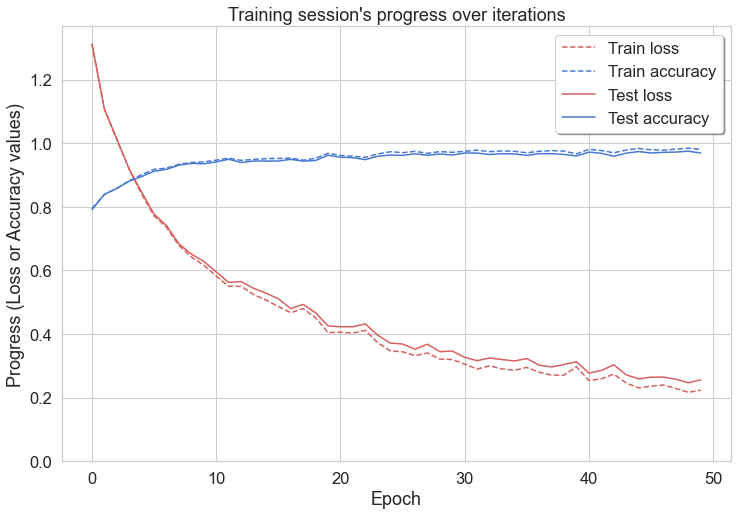

In [7]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "b--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "b-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Progress (Loss or Accuracy values)')
plt.xlabel('Epoch')
plt.ylim(0)

plt.show()

In [25]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

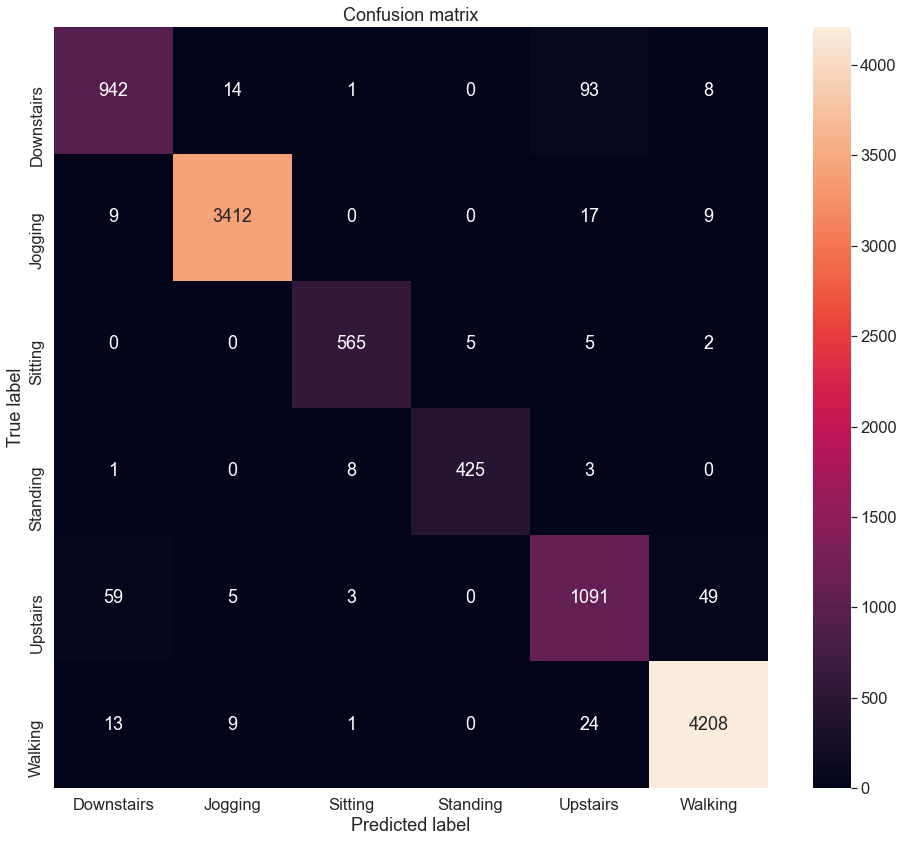

In [26]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [1]:

from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


198/axis"
  attr {
    key: "N"
    value {
      i: 2
    }
  }
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "Tidx"
    value {
      type: DT_INT32
    }
  }
}
node {
  name: "rnn/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/MatMul_198"
  op: "MatMul"
  input: "rnn/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/concat_198"
  input: "rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/read"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "transpose_a"
    value {
      b: false
    }
  }
  attr {
    key: "transpose_b"
    value {
      b: false
    }
  }
}
node {
  name: "rnn/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/BiasAdd_198"
  op: "BiasAdd"
  input: "rnn/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/MatMul_198"
  input: "rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias/read"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "data_format"
    value {
      s: "NHWC"
    }
  }
}
node {
  name: